In [4]:
import os 

print(os.getcwd())

import KITTI_dataset_s
from KITTI_dataset_s import getSavePath, parse_args, SatGrdDatasetTest
import KITTI_dataset_s 
from models_kitti import Model
# from dataLoader.KITTI_dataset import SatGrdDatasetTest
import matplotlib.gridspec as gridspec
from jacobian import grid_sample

import torch
from torch.utils.data import DataLoader
import numpy as np 
from matplotlib import pyplot as plt
from math import sin, cos

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

np.random.seed(2022)

args = parse_args()

save_path = getSavePath(args)
net = Model(args)
net.to(device)

net.load_state_dict(torch.load(os.path.join(save_path, 'model_4.pth')), strict=False)

c:\Users\dimitris\Desktop\MyFiles\diplomatikh\pytorch-tensorflow\pytorch\Cross-View-Localization\Boosting3DoFAccuracy
save_path: ./ModelsKitti/3DoF/lat20.0m_lon20.0m_rot10.0_Nit2_TransV1G2SP_CrossAttn_Uncertainty


<All keys matched successfully>

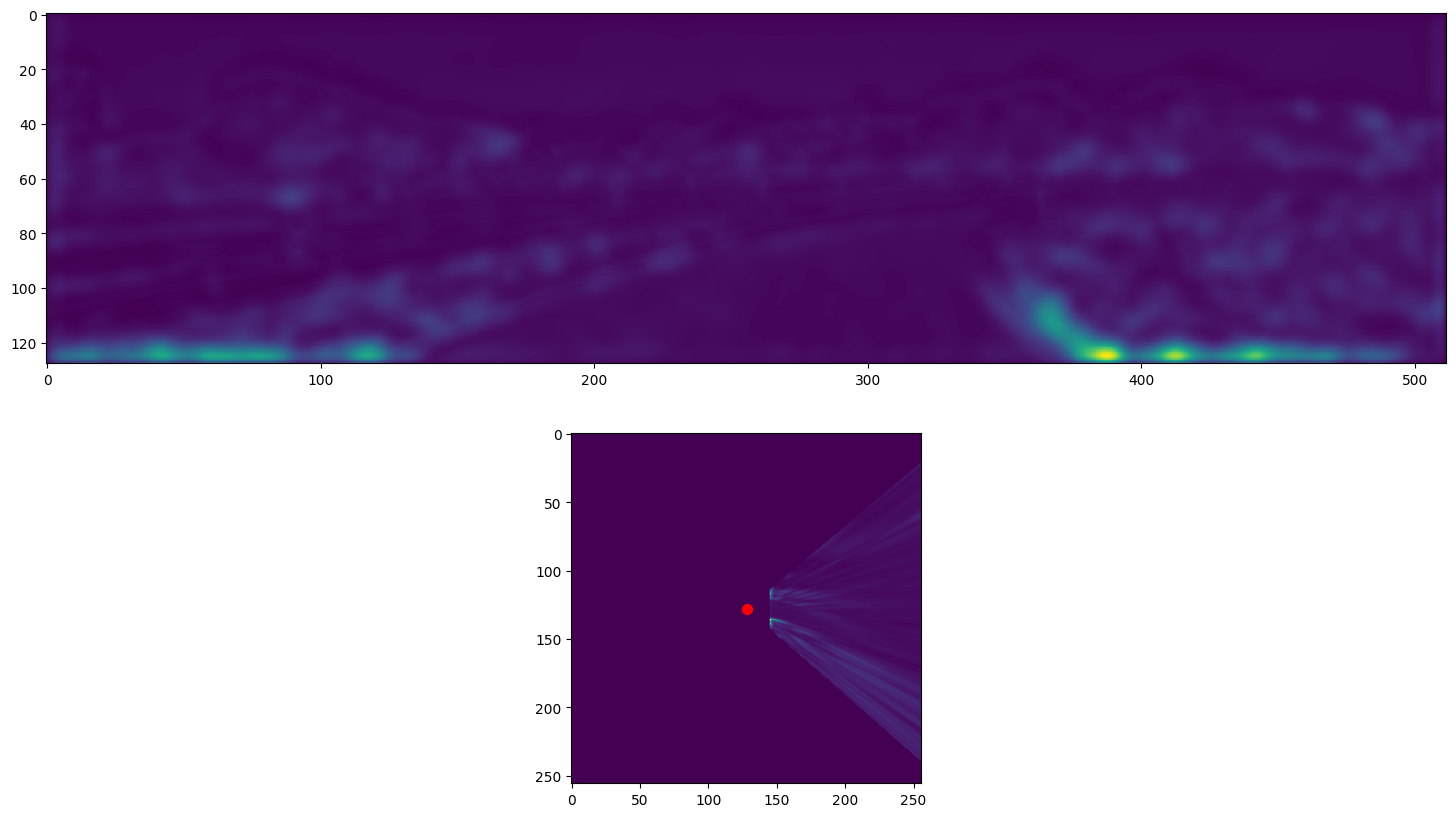

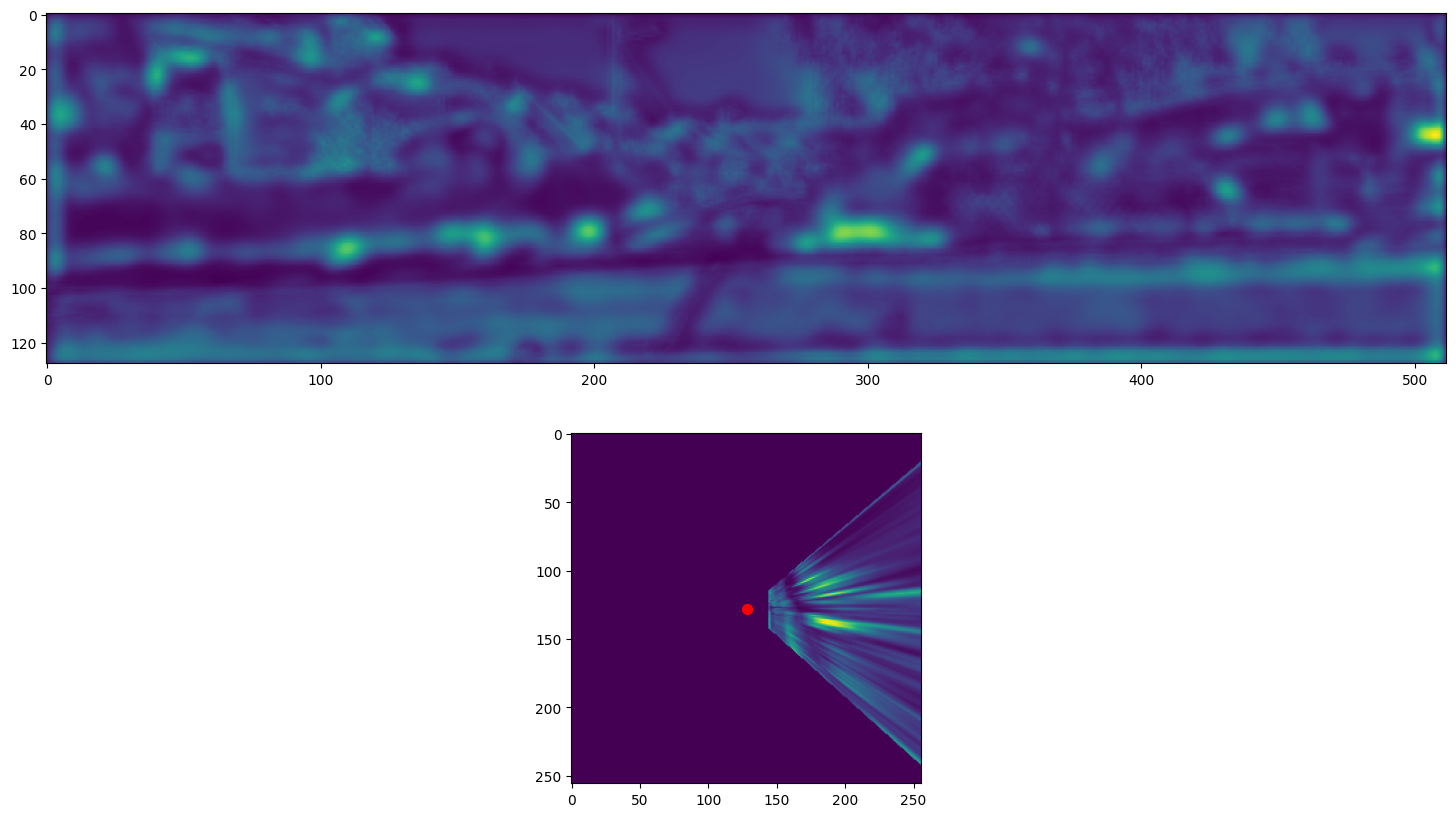

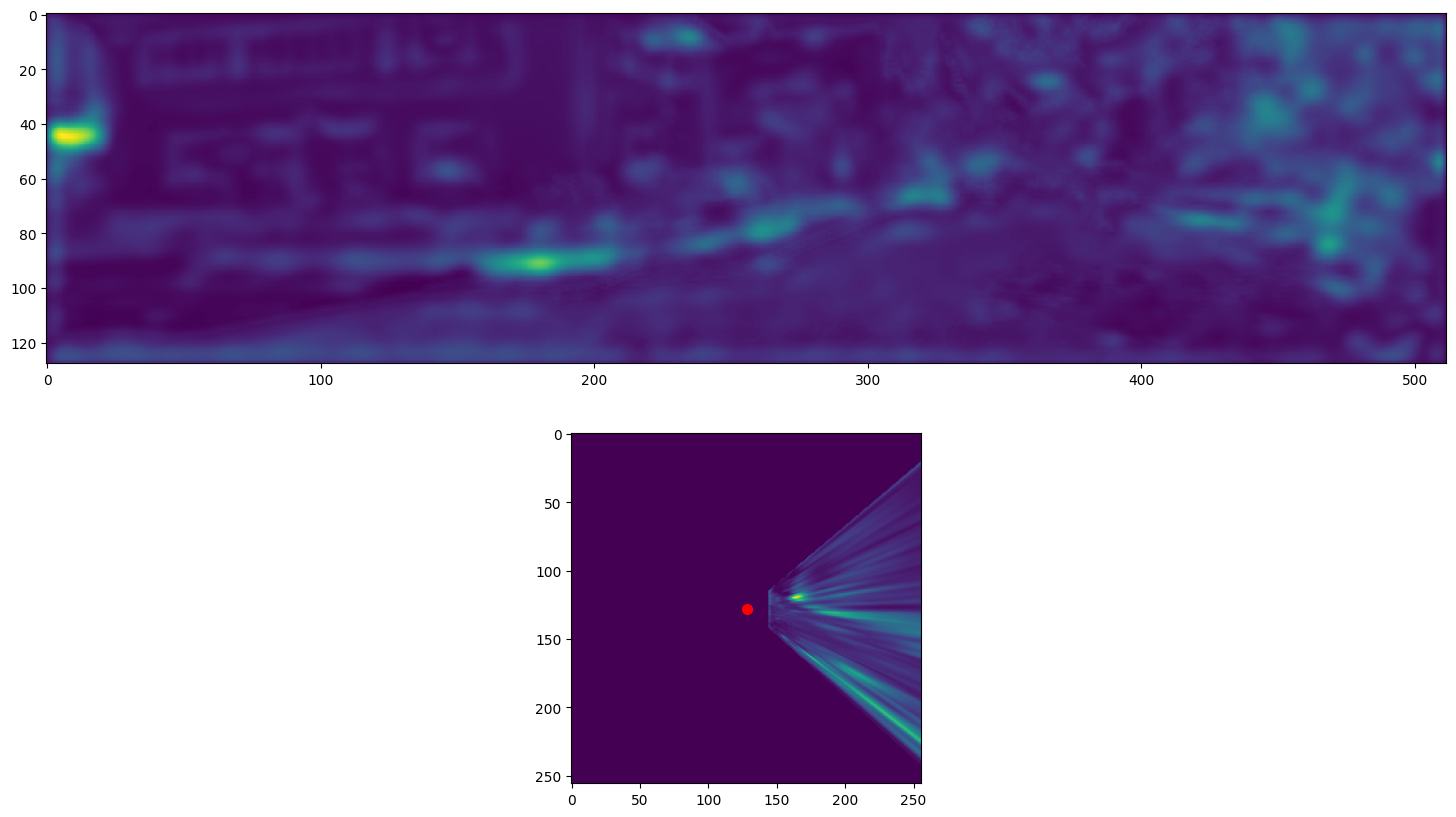

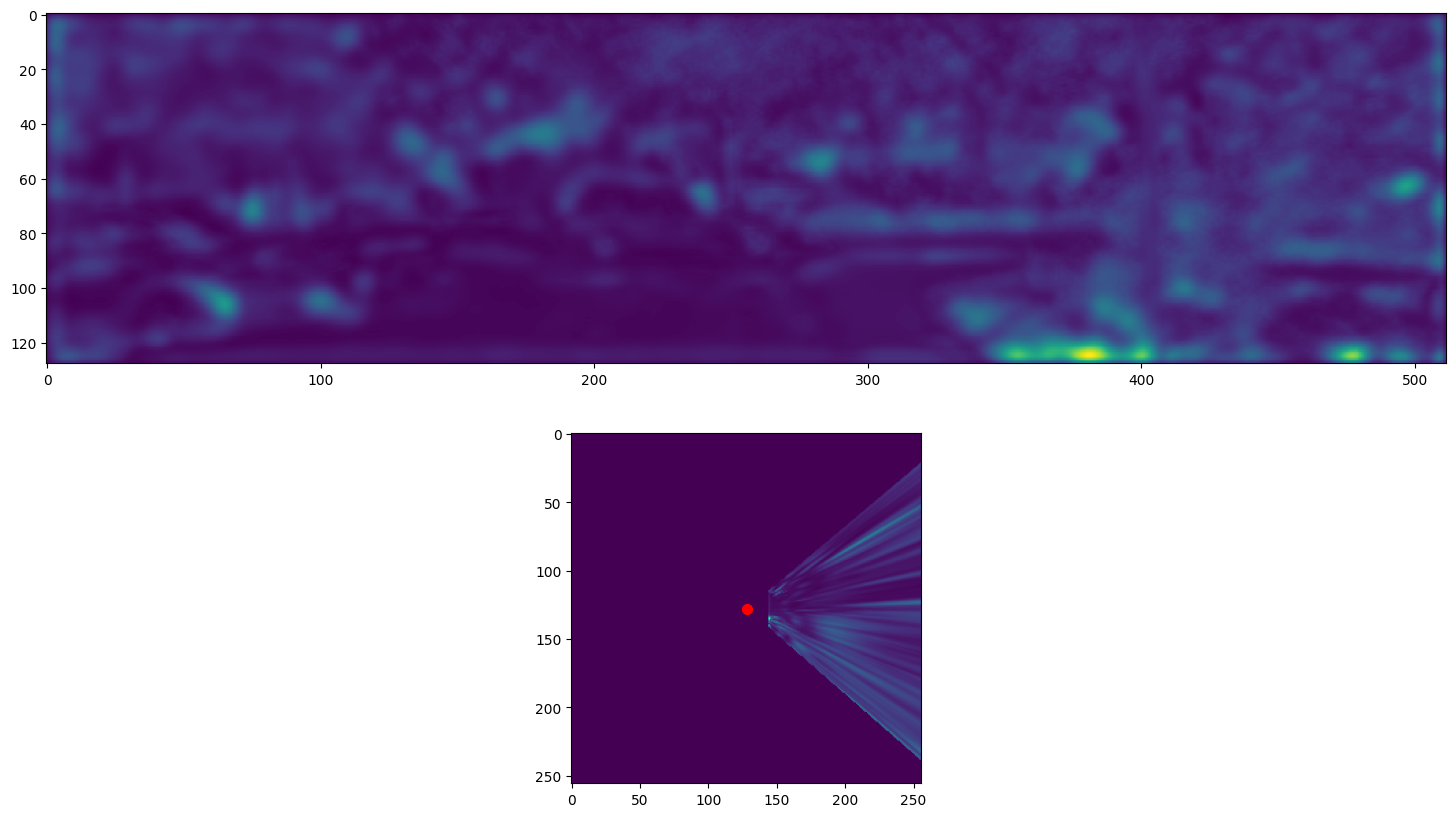

In [5]:
shift_range_lat=20; shift_range_lon=20; rotation_range=10
batch_size = 1


dataset = SatGrdDatasetTest(root = KITTI_dataset_s.root_dir, file=KITTI_dataset_s.test1_file,
                            transform=(KITTI_dataset_s.satmap_transform, KITTI_dataset_s.grdimage_transform),
                            shift_range_lat=args.shift_range_lat,
                            shift_range_lon=args.shift_range_lon,
                            rotation_range=args.rotation_range)


for i in range(4):
    with torch.no_grad():
        fig = plt.figure(figsize=(20, 10))
        # gs = gridspec.GridSpec(2, 2)
        # ax1 = fig.add_subplot(gs[0, 0:2])# This spans all columns in the first row


        data = dataset[i]
        sat_map, left_camera_k, grd_img_left, gt_shift_u, gt_shift_v, gt_heading, file_paths, test_data = [item.to(device).unsqueeze(0) if type(item) == torch.Tensor else item for item in data]
        B, _, ori_grdH, ori_grdW = grd_img_left.shape

        sat_feat_list, sat_conf_list = net.SatFeatureNet(sat_map) 
        grd8, grd4, grd2 = net.GrdEnc(grd_img_left)
        grd_feat_list = net.GrdDec(grd8, grd4, grd2)


        
        shift_u = torch.zeros([B, 1], dtype=torch.float32, requires_grad=True, device=sat_map.device) #- 0.0 -> 10 meters 
        shift_v = torch.zeros([B, 1], dtype=torch.float32, requires_grad=True, device=sat_map.device) #+ 0.0 -> 10 meters 
        heading = torch.zeros([B, 1], dtype=torch.float32, requires_grad=True, device=sat_map.device) #+ 1.0 -> 10 degress

        level = 2
        grd_feat = grd_feat_list[level]
        sat_feat = sat_feat_list[level]

        #F()-> project_grd_to_map
        B, C, H, W = grd_feat.shape

        XYZ_1 = net.sat2world(sat_feat.shape[-1]) 
        uv, mask = net.World2GrdImgPixCoordinates(shift_u, shift_v, heading, XYZ_1, left_camera_k,
                                                   H, W, ori_grdH, ori_grdW)
        
        #F()-> grid_sample(grd_feat, uv)
        # grd_f_trans, _ = grid_sample(grd_feat, uv, jac=None)
        image = grd_feat.clone(); optical = uv.clone()
        N, C, IH, IW = image.shape
        _, H, W, _ = optical.shape #

        ix = optical[..., 0].view(N, 1, H, W)
        iy = optical[..., 1].view(N, 1, H, W)

        with torch.no_grad():
            ix_nw = torch.floor(ix)  # north-west  upper-left-x
            iy_nw = torch.floor(iy)  # north-west  upper-left-y
            ix_ne = ix_nw + 1        # north-east  upper-right-x
            iy_ne = iy_nw            # north-east  upper-right-y
            ix_sw = ix_nw            # south-west  lower-left-x
            iy_sw = iy_nw + 1        # south-west  lower-left-y
            ix_se = ix_nw + 1        # south-east  lower-right-x
            iy_se = iy_nw + 1        # south-east  lower-right-y

            torch.clamp(ix_nw, 0, IW -1, out=ix_nw)
            torch.clamp(iy_nw, 0, IH -1, out=iy_nw)

            torch.clamp(ix_ne, 0, IW -1, out=ix_ne)
            torch.clamp(iy_ne, 0, IH -1, out=iy_ne)

            torch.clamp(ix_sw, 0, IW -1, out=ix_sw)
            torch.clamp(iy_sw, 0, IH -1, out=iy_sw)

            torch.clamp(ix_se, 0, IW -1, out=ix_se)
            torch.clamp(iy_se, 0, IH -1, out=iy_se)

        mask_x = (ix >= 0) & (ix <= IW - 1)
        mask_y = (iy >= 0) & (iy <= IH - 1)
        mask = mask_x * mask_y

        assert torch.sum(mask) > 0
        
        nw = (ix_se - ix) * (iy_se - iy) * mask #bilinear sampling weights [N, 1, H, W], the weight is zero if the point dosent hit the camera.
        ne = (ix - ix_sw) * (iy_sw - iy) * mask
        sw = (ix_ne - ix) * (iy - iy_ne) * mask
        se = (ix - ix_nw) * (iy - iy_nw) * mask

        image = image.view(N, C, IH * IW)

        #from accessing 2D to accessing 1D array, if the array was flattened 
        #accesing 
        wtest = (iy_nw * IW + ix_nw).long()
        wtest = wtest.view(N, 1, H * W)

        wtest = wtest.repeat(1, C, 1)

        nw_val = torch.gather(image, 2, (iy_nw * IW + ix_nw).long().view(N, 1, H * W).repeat(1, C, 1)).view(N, C, H, W)
        ne_val = torch.gather(image, 2, (iy_ne * IW + ix_ne).long().view(N, 1, H * W).repeat(1, C, 1)).view(N, C, H, W)
        sw_val = torch.gather(image, 2, (iy_sw * IW + ix_sw).long().view(N, 1, H * W).repeat(1, C, 1)).view(N, C, H, W)
        se_val = torch.gather(image, 2, (iy_se * IW + ix_se).long().view(N, 1, H * W).repeat(1, C, 1)).view(N, C, H, W)

        grd_f_trans = (nw_val * nw + ne_val * ne + sw_val * sw + se_val * se)



        auv = uv[0].cpu().numpy()
        i = 21
        grd_feat = grd_feat[0].cpu().permute([1,2,0])[...,i*3:(i+1)*3]
        grd_f_trans = grd_f_trans[0].cpu().permute([1,2,0])[...,i*3:(i+1)*3]
        
        grd_feat = np.array(grd_feat)
        grd_feat = (grd_feat - np.min(grd_feat)) / (np.max(grd_feat) - np.min(grd_feat))

        grd_f_trans = np.array(grd_f_trans)
        grd_f_trans = (grd_f_trans - np.min(grd_f_trans)) / (np.max(grd_f_trans) - np.min(grd_f_trans))

        plt.subplot(2, 1, 1)
        plt.imshow(grd_feat)
        plt.subplot(2, 1, 2)
        plt.imshow(grd_f_trans)
        plt.scatter(grd_f_trans.shape[-2]/2, grd_f_trans.shape[-2]/2, color = 'red', s = 50)



        # uv = np.array(uv.cpu()[0])
        # uv_max = uv.max()
        # uv_min = uv.min()
        # uv = (uv - uv_min)/(uv_max-uv_min)
        # uv[:10, :10, :] = 0
        # uv = np.array(uv.cpu()[0])
        # uv = np.sqrt(np.sum(uv**2, axis=-1))
        # ax2.imshow(uv[...,0], cmap='gray')
        # ax3.imshow(uv[...,1], cmap='gray')


        plt.plot()
        stop = 0

In [32]:
xyz_1 = XYZ_1.cpu().numpy()


print(xyz_1.shape)
dx = 0
dz = 1
print(xyz_1[127+dx:129+dx, 127+dz:129+dz, 0])
print(xyz_1[127+dx:129+dx, 127+dz:129+dz, 2])

print(auv[127+dx:129+dx, 127+dz:129+dz, 0])
print(auv[127+dx:129+dx, 127+dz:129+dz, 1])


(256, 256, 4)
[[-0.39165702 -0.39165702]
 [ 0.          0.        ]]
[[0.         0.39165702]
 [0.         0.39165702]]
[[-1.1606365e+08 -4.6031860e+01]
 [ 0.0000000e+00  2.5030814e+02]]
[[4.0485971e+08 1.0969302e+03]
 [4.0485971e+08 1.0969302e+03]]


In [27]:
xyz = torch.tensor([
                    [ 0, 1,-1],
                    [ utils.Camera_height, 0.1, -0.1],
                    [ 0.39, 2, 2]
                    ], dtype=torch.float32).cuda()

print(left_camera_k[0])
uv = left_camera_k[0] @ xyz
uv = uv[:2, :]/ uv[2:, :]
uvt = uv.cpu() * 0.5
print(uvt)


tensor([[592.6800,   0.0000, 500.6163],
        [  0.0000, 490.7390, 126.4406],
        [  0.0000,   0.0000,   1.0000]], device='cuda:0')
tensor([[250.3081, 398.4781, 102.1381],
        [ 63.2203,  75.4888,  50.9518]])


array([[4.0485971e+08, 1.0969302e+03],
       [4.0485971e+08, 1.0969302e+03]], dtype=float32)